# Mapping courts

In [1]:
import os
import sys
sys.path.append('..')

import googlemaps

import csv
import json
import requests

import pandas as pd
import plotly.plotly as py

import matplotlib
%matplotlib inline

from config import settings

## Getting all courts from CAP API

Create a CSV file with all of the courts that exist in the CAP databse. 
<br/>For each court, add the full jurisdiction name. This will be useful for locating it on a Google map.

In [2]:
data_dir = "../%s/court_map" % settings.DATA_DIR
# Create data directory for the project if it doesn't already exist
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    print("Created %s" % data_dir)

In [3]:
# Create courts csv if it doesn't already exist
all_courts_file = '%s/courts.csv' % data_dir
courts_fieldnames = ['court_id', 'court_slug', 'court_name', 'jurisdiction_name', 'jurisdiction_slug']
if not os.path.exists(all_courts_file):
    with open(all_courts_file, 'w+') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=courts_fieldnames)
        writer.writeheader()
    print("Created %s" % all_courts_file)
    
    # Get 100 courts at a time
    # For each court, get full jurisdiction name to help in Google Map searching
    courts_url = "%s/%s/courts/?format=json" % (settings.API_URL, settings.API_VERSION)
    res = requests.get(courts_url).json()
    while True:
        with open(all_courts_file, 'a+', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=courts_fieldnames)
            for court in res['results']:
                jurisdiction_url = court['jurisdiction_url']

                if not jurisdiction_url:
                    # if jurisdiction doesn't exist, skip
                    continue

                jur_res = requests.get(jurisdiction_url).json()

                writer.writerow({
                    'court_id': court['id'],
                    'court_slug': court['slug'],
                    'court_name': court['name'],
                    'jurisdiction_name': jur_res['name_long'],
                    'jurisdiction_slug': jur_res['slug']                    
                })

        if res['next']:
            # Get the next page of court results

            res = requests.get(res['next']).json()

        else:
            # That's it! No more results. 
            print("Done.")
            break

In [4]:
df = pd.read_csv(all_courts_file)
df.head()

,court_id,court_slug,court_name,jurisdiction_name,jurisdiction_slug
0,15658,accomack-cty-cir-ct,Accomack County Circuit Court,Virginia,va
1,13190,adams-cir-ct,Adams Circuit Court,Ohio,ohio
2,17340,adams-cty-cir-ct,Adams County Circuit Court,Ohio,ohio
3,9311,adams-cty-cp,Adams County Court of Common Pleas,Pennsylvania,pa
4,16855,adams-cty-ct-cp,Adams County Court of Common Pleas,Pennsylvania,pa


In [5]:
# remove extra fields for graphing purposes
df.drop(columns=['court_id', 'court_slug', 'jurisdiction_slug'], inplace=True)
df.head()

,court_name,jurisdiction_name
0,Accomack County Circuit Court,Virginia
1,Adams Circuit Court,Ohio
2,Adams County Circuit Court,Ohio
3,Adams County Court of Common Pleas,Pennsylvania
4,Adams County Court of Common Pleas,Pennsylvania


## Graph court numbers per jurisdiction

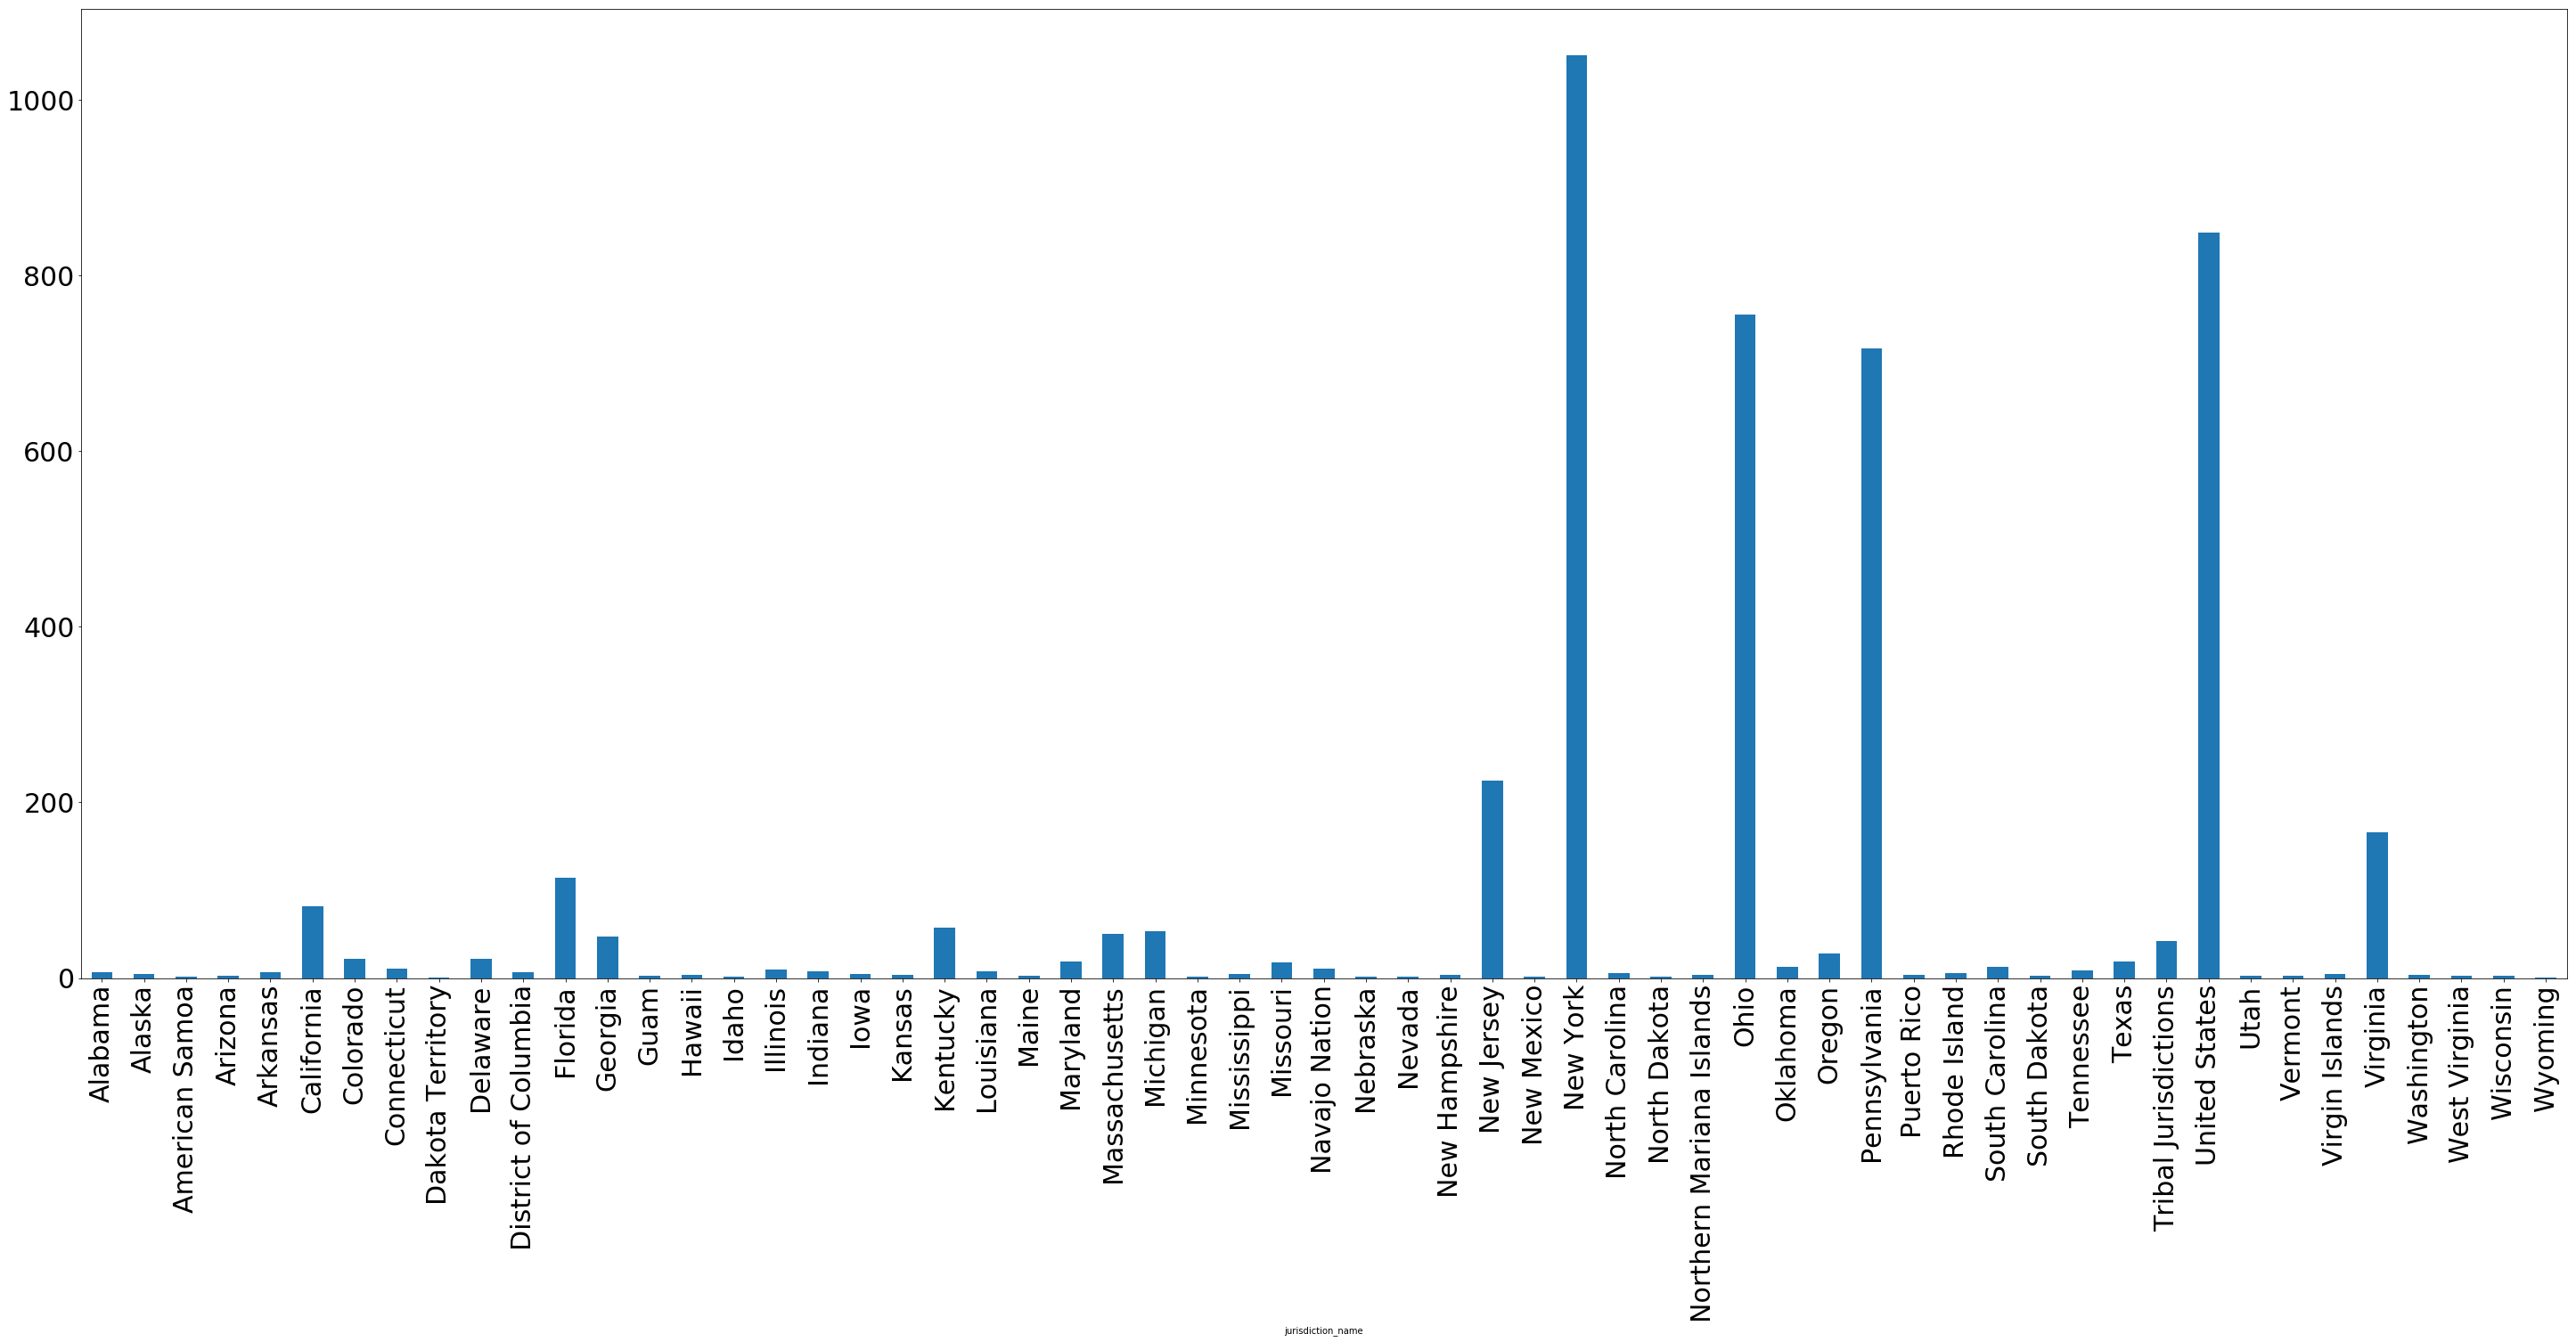

In [6]:
aggregated_df = df.groupby(['jurisdiction_name']).agg(['count'])
aggregated_df.plot(kind='bar', legend=False, figsize=(50, 20), fontsize=30)

## Get all currently active courts by finding them using the Google maps API

This section requires a google key to exist in the settings file.
<br/>
You can get a year for free by signing up here: https://cloud.google.com/maps-platform/


In [10]:
# This will take time to run. You can interrupt the process at any time if it's taking too long to get just a fraction 
gmaps = googlemaps.Client(key=settings.GOOGLE_API_KEY)

active_courts = '%s/active_courts.csv' % data_dir

if not os.path.exists(active_courts):
    with open(active_courts, 'a+') as csvfile:
        fieldnames = courts_fieldnames + ['addresses', 'longitudes', 'latitudes', 'google_ids']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        print("Created %s" % active_courts)
        
        with open(all_courts_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for court_row in reader:
                court = court_row
                court['longitudes'] = []
                court['latitudes'] = []
                court['addresses'] = []
                court['google_ids'] = []
                geocode_results = gmaps.geocode(court_row['court_name'])
                # because there can be multiple possible results in Google
                # iterate through all of them, try to match them on jurisdiction,
                # deal with multiple results later
                for gmap_res in geocode_results:
                    for component in gmap_res['address_components']:
                        if 'administrative_area_level_1' in component['types']:
                            jurisdiction = component['long_name']
                            # only log if jurisdiction matches Google's location 
                            if jurisdiction == court_row['jurisdiction_name']:
                                court['addresses'].append(gmap_res['formatted_address'])
                                court['longitudes'].append(gmap_res['geometry']['location']['lng'])
                                court['latitudes'].append(gmap_res['geometry']['location']['lat'])
                                court['google_ids'].append(gmap_res['place_id'])
                              
                            
                # Once we have all possible results, add them to the csvfile
                # Only add them if longs and lats exist
                if len(court['longitudes']) and len(court['latitudes']):
                    writer.writerow(court)
    print("Done.")
    brea
else:
    print("%s exists. Please delete it first and then rerun to recreate data." % active_courts)

Created ../data/court_map/active_courts.csv
Done.


In [8]:
df = pd.read_csv(active_courts)
df.head()

,court_id,court_slug,court_name,jurisdiction_name,jurisdiction_slug,addresses,longitudes,latitudes,google_ids
0,15658,accomack-cty-cir-ct,Accomack County Circuit Court,Virginia,va,"['23316 Courthouse Ave, Accomac, VA 23301, USA']",[-75.67130999999999],[37.7197325],['ChIJY3OCbffUu4kRR3wE_jSamKY']
1,9311,adams-cty-cp,Adams County Court of Common Pleas,Pennsylvania,pa,"['117 Baltimore St, Gettysburg, PA 17325, USA']",[-77.23148499999999],[39.829555],['ChIJq8Zvto2syYkR9ZZeGmAUJHY']
2,16855,adams-cty-ct-cp,Adams County Court of Common Pleas,Pennsylvania,pa,"['117 Baltimore St, Gettysburg, PA 17325, USA']",[-77.23148499999999],[39.829555],['ChIJq8Zvto2syYkR9ZZeGmAUJHY']
3,9701,adams-cty-orphans-ct,Adams County Orphans' Court,Pennsylvania,pa,"['117 Baltimore St 103 \u200b, Gettysburg, PA ...",[-77.231629],[39.829344],['ChIJq8Zvto2syYkRjOeiylgA2xE']
4,11867,adams-orphans-ct,Adams County Orphans' Court,Pennsylvania,pa,"['117 Baltimore St 103 \u200b, Gettysburg, PA ...",[-77.231629],[39.829344],['ChIJq8Zvto2syYkRjOeiylgA2xE']


In [83]:
# Reformat dataframe to use the first values of longitudes and latitudes for now

df.loc[:, 'longitudes'] = df.longitudes.apply(lambda x: json.loads(x)[0])
df.loc[:, 'latitudes'] = df.latitudes.apply(lambda x: json.loads(x)[0])
df.head()

,court_id,court_slug,court_name,jurisdiction_name,jurisdiction_slug,addresses,longitudes,latitudes,google_ids
0,15658,accomack-cty-cir-ct,Accomack County Circuit Court,Virginia,va,"['23316 Courthouse Ave, Accomac, VA 23301, USA']",-75.671310,37.719732,['ChIJY3OCbffUu4kRR3wE_jSamKY']
1,9311,adams-cty-cp,Adams County Court of Common Pleas,Pennsylvania,pa,"['117 Baltimore St, Gettysburg, PA 17325, USA']",-77.231485,39.829555,['ChIJq8Zvto2syYkR9ZZeGmAUJHY']
2,16855,adams-cty-ct-cp,Adams County Court of Common Pleas,Pennsylvania,pa,"['117 Baltimore St, Gettysburg, PA 17325, USA']",-77.231485,39.829555,['ChIJq8Zvto2syYkR9ZZeGmAUJHY']
3,9701,adams-cty-orphans-ct,Adams County Orphans' Court,Pennsylvania,pa,"['117 Baltimore St 103 \u200b, Gettysburg, PA ...",-77.231629,39.829344,['ChIJq8Zvto2syYkRjOeiylgA2xE']
4,11867,adams-orphans-ct,Adams County Orphans' Court,Pennsylvania,pa,"['117 Baltimore St 103 \u200b, Gettysburg, PA ...",-77.231629,39.829344,['ChIJq8Zvto2syYkRjOeiylgA2xE']


## Map the data
Set up map data for plotly
In order to use plotly you will need to have an account: https://plot.ly/accounts/login/

In [84]:
data = [ dict(
        type='scattergeo',
        locationmode='USA-states',
        lon=df['longitudes'],
        lat=df['latitudes'],
        text=df['court_name'],
        mode='markers')]
layout = dict(
        title = 'United States courts',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland=True,
            landcolor="rgb(250, 250, 250)",
            subunitcolor="rgb(217, 217, 217)",
            countrycolor="rgb(217, 217, 217)",
            countrywidth=0.5,
            subunitwidth=0.5
        ),
    )

In [85]:
# Graph map data
fig = dict( data=data, layout=layout )
py.iplot(fig, validate=False, filename='us_courts' )